### Imports

In [1]:
import numpy as np
from bond_pricing import annuity_rate, bond_coupon_periods, bond_price_breakup, equiv_rate, bond_yield
import isda_daycounters
from pandas import to_datetime
from scipy.optimize import newton

### No-Arbitrage Price - Spot Curve

The starting place in no‐arbitrage bond valuation is the zero‐coupon (or spot) yield curve and these rates are used to value coupon bonds.

No-arbitrage price for a 4-year, 4% annual coupon payment corporate bond.

Assume that the sequence of zero-coupon bond yields is `[3.5%, 3.8%, 4.1%, and 4.2%]`, an upward-sloping spot curve. (“Spot rate” is a commonly used synonym for zero‐coupon rate.)

Generalization of the bond pricing equation:
$$PV=\frac{PMT}{(1+\mathit{z}_{1})^{1}}+\frac{PMT}{(1+\mathit{z}_{2})^{2}}+ \cdots + \frac{PMT+PV}{(1+\mathit{z}_{N})^{N}}$$

PV is the no‐arbitrage value of the N‐period bond—the sum of the present values of the cash flows, each of which is discounted using the zero‐coupon rate that corresponds to the period ($\mathit{z}_{1}, \mathit{z}_{2}, \cdots, \mathit{z}_{N}$), PMT is the coupon payment per period, and FV is the principal (usually taken to be 100 so the price can be interpreted as the percentage of par value).

Given a particular bond price, the yield to maturity is the internal rate of return (IRR) on the cash flows. An IRR is the uniform discount rate such that the sum of the present values of the future cash flows discounted at that particular interest rate for each time period equals the price of the bond.

The correct way to think about a **yield to maturity is as a summary statistic** about the cash flows on the bond which does not presume a flat yield curve. It is a **present value weighted average** of the sequence of zero‐coupon rates with most of the weight on the last cash flow. 

In [2]:
spot_rates1 = np.array([0.035, 0.038, 0.041, 0.042])
coupon_rate = 0.04
fv = 100
years = 4
per = 1

def bond_price_spot_rate(coupon_rate, fv, years, per, spot_rates):
  coupon = fv * coupon_rate / per 
  cash_flows = np.full(years, coupon) 
  cash_flows[years-1] += fv
  period = np.arange(1, years+1)
  pv_cf = cash_flows / (1 + spot_rates/per)**(period*per)
  return np.sum(pv_cf)

pv = bond_price_spot_rate(coupon_rate=coupon_rate, fv=fv, years=years, per=per, spot_rates=spot_rates1)
print(f'{pv = :0.3f}')
ytm = annuity_rate(n_periods=years, instalment=fv*coupon_rate, pv=pv, terminal_payment=fv)
print(f'{ytm = : 0.5f}')

pv = 99.342
ytm =  0.04182


In [3]:
spot_rates1 = np.array([0.035, 0.038, 0.041, 0.042]) # upward sloping zero-coupon curve
spot_rates2 = np.array([0.0492, 0.0469, 0.043, 0.0416]) # downward sloping spot curve
spot_rates3 = np.array([0.0213, 0.0282, 0.0365, 0.0425])
spot_rates4 = np.array([0.04182, 0.04182, 0.04182, 0.04182])

rates = [spot_rates1, spot_rates2, spot_rates3, spot_rates4]

for spot_rate in rates:
  pv = bond_price_spot_rate(coupon_rate=coupon_rate, fv=fv, years=years, per=per, spot_rates=spot_rate)
  print(f'{pv = :0.3f}')

pv = 99.342
pv = 99.342
pv = 99.342
pv = 99.342


### Bond Prices and Yields

The yield to maturity ($\mathit{y}$) per period is the internal rate of return given the cash flows.

$$PV=\frac{PMT}{(1+\mathit{y})^{1}}+\frac{PMT}{(1+\mathit{y})^{2}}+ \cdots + \frac{PMT+PV}{(1+\mathit{y})^{N}}$$

$$PV=\frac{PMT}{y}\times\left[1 - \frac{1}{(1+y)^{N}}\right]+\frac{FV}{(1+y)^{N}}$$

$$\frac{PV-FV}{FV}=\frac{c-y}{y}\times\left[1-\frac{1}{(1+y)^{N}}\right]$$

Here *c* is the coupon rate per period, PMT/FV. This expression indicates the connection between the price of the bond vis‐à‐vis par value and the coupon rate vis‐à‐vis the yield to maturity. These are the well‐known (and well‐remembered) rules: (1) If the bond is priced at par value (*PV = FV*), the coupon rate and the yield to maturity are equal (*c = y*); (2) if the price is a discount below par value (*PV < FV*), the coupon rate is less than the yield (*c < y*); and (3) if the price is a premium above par value (*PV > FV*), the coupon rate is greater than the yield (*c > y*). These rules apply to a coupon payment date when *N* is an integer.

Alternative arrangement of the bond pricing equation:
$$PV=PMT\left(\frac{1-(1+y)^{-N}}{y}\right)+\frac{FV}{(1+y)^N}$$
$$FV_{n}=PMT\left[\frac{(1+y)^{N}-1}{y}\right]+TV$$
$$PMT=\left[\frac{PV - \frac{FV}{(1+y)^N}}{\frac{1-(1+y)^{-N}}{y}}\right]$$

In [4]:
def pv(r, n, pmt, fv, beg=False):
  old_settings = np.seterr(invalid='ignore')
  pvPMT = np.where(r == 0, n, np.divide(1 - (1+r)**-n, r)) * pmt
  np.seterr(**old_settings)
  pvFV = fv / (1 + r)**n
  
  return np.where(beg, (pvPMT + pvFV) * (1 + r), pvPMT + pvFV)

def fv(r, n, pmt, terminal_payment, beg=False):
  old_settings = np.seterr(invalid='ignore')
  fvPMT = np.where(r == 0, n, np.divide((1+r)**n - 1, r)) * pmt
  np.seterr(**old_settings)
  TV = terminal_payment
  
  return np.where(beg, fvPMT * (1 + r) + TV, fvPMT + TV)

def pmt(r, n, pv, fv):
    return (pv - (fv/(1+r)**n)) / np.divide(1 - (1+r)**-n, r)

### Yield Statistics

- **Yield-to-Maturity** is also called the *Redemption Yield*.
  - YTM is typically stated in *street convention* such that regardless of whether the future cash flow dates fall on a holiday/weekend, it is considered to be received in regular intervals. This convention produces an IRR using integers as exponents.
  - *True yield* statistics solves the IRR given the specific calendar dates for cash flows based on some schedule of bank holidays.
- **Current Yield** also called the *running yield* and the *income yield*; it is the annual coupon payment divided by the price of the bond. 
  - $\text{Coupon Yield}=\frac{PMT}{PV}$
- **Simple Yield** also called the *Japanese* simple yield; it is the coupon payment plus the straight-line amortization of the gain (buying at discount) or loss (buying at premium) divided by the price of the bond. 
  - $\text{Simple Yield}=\frac{PMT + \left(\frac{FV - PV}{N}\right)}{PV}$
- **Approx. Yield to Maturity** is divides the coupon payment and the straight-line amortization of the gain/loss by the average of the current price and the redemption payment. 
  - $\text{Approx. Yield-to-Maturity}=\frac{PMT + \left(\frac{FV - PV}{N}\right)}{\frac{PV + FV}{2}}$
  - This approximation is usually used as the first 'guess' or starting place in the trial-and-error search algorithms that determine the IRR where NPV of cash flows equates to 0 (Newton's method, binary search, etc.)
- **U.S. Government Equivalent** is a recalibrated yield using an actual/actual day-count convention instead of 30/360. US Government Equivalent should be used to compute a bond's spread over a benchmark Treasury bond.

In [5]:
N = 4
presentvalue = 99.342
facevalue = 100
coupon = 4

def current_yield(pmt, pv):
    return pmt / pv

def simple_yield(pv, fv, N, pmt):
    return (pmt + (fv  - pv)/N) / pv

def approx_ytm(pv, fv, N, pmt):
    return (pmt + (fv  - pv)/N) / ((pv + fv)/2)

def equivRate(rate, from_freq=1, to_freq=1):
  if from_freq == np.inf:
    return (np.exp(rate / to_freq) - 1) * to_freq
  elif to_freq == np.inf:
    return np.log(1 + rate / from_freq) * from_freq
  else:
    rate = np.log(1 + rate / from_freq) * from_freq
    return (np.exp(rate / to_freq) - 1) * to_freq

print(current_yield(coupon, presentvalue))
print(simple_yield(presentvalue, facevalue, N, coupon))
print(approx_ytm(presentvalue, facevalue, N, coupon))

0.04026494332709227
0.04192083912141894
0.04178246430757192


### Horizon Yields

Horizon yield (holding period rate of return) analysis can be done ex-ante using projected future rates or ex-post using actual realized rates. The analysis considers price and **yield at the time of sale** of the bond (if sold before maturity), which reflects the future buyer's required rate of return to hold the bond for the remainder of the time to maturity, and the **coupon payment reinvestment rate** (assuming constant coupon reinvestment rate (CRR)).

Holding period return (HPR) over the time to maturity depends only on the CRR. When the bond is sold prior to maturity, the HPR is a function also of the price (and yield) at the time of sale. The objective here is to see the connection between the HPR and the traditional YTM (yield to maturity) statistic.

That total return is the sum of the reinvested coupon payments plus the final coupon and principal. The first coupon is reinvested for three years, the second for two years, and the third for one year.

$$\text{Total Return}=\left[PMT\times\left(1+CRR\right)^{N-1}\right]+\left[PMT\times\left(1+CRR\right)^{N-2}\right]+\cdots+\left[PMT\times\left(1+CRR\right)^{N-(N-1)}\right]+FV$$
Suppose that CRR = YTM
$$\text{Total Return}=PMT\left[\frac{(1+y)^{N}-1}{y}\right]+FV$$

Solve for the horizon yield—the annual rate of return that connects the purchase price and the total return at maturity.
$$\text{HPR}=\left[\left(\frac{\text{Total Return}}{PV}\right)^{\frac{1}{N\times PER}}-1\right]\times PER$$

This equation shows the well‐known result that the yield to maturity measures the **investor’s rate of return only if the coupons are reinvested at that same yield**. This is a standard caveat for internal rates of return in general.

Formalized as follows:
- If CRR = YTM, then HPR = YTM.
- If CRR > YTM then HPR > YTM.
- If CRR < YTM then HPR < YTM.

In [6]:
years = 4
coupon = 4
principal = 100
ytm = 0.04182 

total_return = fv(ytm, years, coupon, principal, beg=False)
print(f'{total_return :0.3f}')

117.032


### Implied Probability of Default on Coupon Bonds

In [7]:
per = 1

# 4-year, 4% annual payment corporate bond
cop_mat = 4
cop_pv = 99.342
coupon = 4
cop_yield = annuity_rate(n_periods=cop_mat, instalment=coupon, pv=cop_pv, terminal_payment=100)

# Equivalent 4-year government bond
gov_mat = 4
gov_yield = 0.035
gov_pv = pv(gov_yield, gov_mat, coupon, 100)

credit_spread = cop_yield - gov_yield
price_spread = gov_pv - cop_pv

In [8]:
from prettytable import PrettyTable

# Probability of Default Calculation - Unconditional Probability
year = np.arange(1, cop_mat+1)
probability_default = ['Q' for _ in year]

# Risk-Free Value (value of the corporate bond if it were risk free, coupon payments at the beginning of the period)
riskfree_value = np.array([np.round(pv(gov_yield, gov_mat - i + 1, coupon, 100, beg=True), 3) for i in year])

# Recovery assuming a recovery rate of 40% of par value (unlike zero-coupon bond, recovery is a constant fraction of par instead of risk-free value)
recovery_rate = 0.4 # Depending on the industry and the rank of the bond in the debt structure
recovery = np.array([round(100 * recovery_rate, 3) for _ in year])

# Default Loss after instantaneous recovery - loss at the time if default occurs—it is the riskfree value minus recovery
default_loss = np.array([round(riskfree_value[i-1] - recovery[i-1], 3) for i in year])

# Present value of default loss - risk-free rate is used to discount the losses
pv_default = np.array([round(default_loss[i-1]/((1+gov_yield/per)**(i*per)),3) for i in year])
# Here the present values turn out to be the same for each year—that’s because the bond is zero-coupon 
# and the recovery rate is assumed to be a constant share of the loss.

# Present Value of Expected Loss
expected_loss = np.array([str(default) + ' * Q' for default in pv_default])

# Output Table
table = PrettyTable()
table.add_column("Year", year)
table.add_column("Prob. of Default", probability_default)
table.add_column("Risk-Free Value", riskfree_value)
table.add_column("Recovery", recovery)
table.add_column("Default Loss", default_loss)
table.add_column("PV of Default Loss", pv_default)
table.add_column("Expected Loss", expected_loss)
print(table)

Q = price_spread/np.sum(pv_default) # implied default probability
print(f'{Q = :%}')

approx_implied_default_prob = credit_spread/(1 - recovery_rate)
print(f'{approx_implied_default_prob = :%}')

+------+------------------+-----------------+----------+--------------+--------------------+---------------+
| Year | Prob. of Default | Risk-Free Value | Recovery | Default Loss | PV of Default Loss | Expected Loss |
+------+------------------+-----------------+----------+--------------+--------------------+---------------+
|  1   |        Q         |     105.401     |   40.0   |    65.401    |       63.189       |   63.189 * Q  |
|  2   |        Q         |      104.95     |   40.0   |    64.95     |       60.632       |   60.632 * Q  |
|  3   |        Q         |     104.483     |   40.0   |    64.483    |       58.16        |   58.16 * Q   |
|  4   |        Q         |      104.0      |   40.0   |     64.0     |       55.772       |   55.772 * Q  |
+------+------------------+-----------------+----------+--------------+--------------------+---------------+
Q = 1.049215%
approx_implied_default_prob = 1.136751%


### Bond Pricing Between Coupon Dates

Suppose that the current coupon period covers $T$ days and that the bond is being priced for settlement $t$ days into the period. Therefore, $t/T$ is the fraction of the period that has gone by and $1 – t/T$ is the fraction that remains.

General version of the formula:
$$\text{Flat} + \text{AI} = \frac{PMT}{(1+y)^{1-t/T}} + \frac{PMT}{(1+y)^{2-t/T}} + \cdots + \frac{PMT + FV}{(1+y)^{N-t/T}}$$

The next coupon payment is discounted back over the fraction of the period ($1 – t/T$) until that cash flow is received; the following payment adds a full period to that fraction ($2 – t/T$), and so forth.

The left side is the sum of the present values of the cash flows and is the full price for the bond on the settlement date. That **full price**, which often is called the **dirty or invoice price** in practice, is decomposed into the **flat price** ($Flat$), which also is called the **clean price**, and the **accrued interest** ($AI$).

Accrued interest is the compensation to the seller of the bond for interest income since the last coupon date. It is calculated as a straight‐line share of the forthcoming payment. It is the fraction of the period that has elapsed times the amount of the payment.

$$AI=t/T\times PMT$$

Determining the fraction $t/T$ depends on the day‐count convention specified in the bond’s documentation.

Multiply the numerator and denominator by $(1 + y)^{t/T}$ in equation above and substitute in equations full price equation to get a general closed‐form relationship between the present and future cash flows and the yield‐to‐maturity statistic.

$$\text{Flat} + (t/T \times PMT) = \left[\frac{PMT}{y} \times \left(1-\frac{1}{(1+y)^{N}}\right) + \frac{FV}{(1+y)^{N}}\right]\times (1+y)^{t/T}$$
$$\text{Flat} + (t/T \times PMT) =\left[PMT\left(\frac{1-(1+y)^{-N}}{y}\right)+\frac{FV}{(1+y)^N}\right] \times (1+y)^{t/T}$$

In [9]:
issuance = to_datetime('2010-11-15')
settlement = to_datetime('2011-02-14')
maturity = to_datetime('2020-11-15')
daycount = 'thirty/360'
installment = 8
y = 0.08
facevalue = 100
N = 10
per = 2

coupon_periods = bond_coupon_periods(settle=settlement, mat=maturity, freq=2, daycount=daycount)
print("{" + ",\n".join("{!r}: {!r}".format(k, v) for k, v in coupon_periods.items()) + "}")

price_breakup = bond_price_breakup(settle=settlement, cpn=installment/100, mat=maturity,
               yld=y, freq=2, comp_freq=2,
               face=100, redeem=facevalue, daycount=daycount)

print()
print("{" + ",\n".join("{!r}: {!r}".format(k, v) for k, v in price_breakup.items()) + "}")

print()
tT = coupon_periods['accrual_fraction']
accrued_interest = (tT * installment/per)
print(f'{accrued_interest = :0.5f}')
flat_price = (pv(y/per, N*per, installment/per, facevalue) * (1 + y/per)**tT) - accrued_interest
print(f'{flat_price = }')
full_price = (pv(y/per, N*per, installment/per, facevalue) * (1 + y/per)**tT)
print(f'{full_price = }')

{'n': 20,
'discounting_fraction': 0.5055555555555555,
'accrual_fraction': 0.49444444444444446,
'next_coupon': Timestamp('2011-05-15 00:00:00'),
'prev_coupon': Timestamp('2010-11-15 00:00:00')}

{'DirtyPrice': 101.95817189458909,
'AccruedInterest': 1.9777777777777779,
'CleanPrice': 99.98039411681131,
'NextCoupon': Timestamp('2011-05-15 00:00:00'),
'PreviousCoupon': Timestamp('2010-11-15 00:00:00')}

accrued_interest = 1.97778
flat_price = 99.98039411681131
full_price = 101.95817189458909


The U.S. government equivalent yield (yield recalibrated to actual/actual day count convention) for this bond turns out to be 8.0050% (s.a.), slightly above the street convention yield. It is the solution for the yield to maturity using 91/181 on the right side of the equation instead of 89/180.

In [10]:
def gov_equiv_yield(y, N, pmt, price, fv, per, tT):
    
    def f(y): # The function whose zero is to be found
        return (pv(y/per, N*per, pmt/per, fv) * (1 + y/per)**tT) - price
    
    root, status = newton(f, y, full_output=True, disp=False)
    return root

tT = bond_coupon_periods(settle=settlement, mat=maturity, freq=2, daycount='actual/actual')['accrual_fraction']
equiv_yield = gov_equiv_yield(y, N, installment, full_price, facevalue, per, tT)
print(f'{tT = :0.5f}')
print(f'{equiv_yield = : 0.6f}')

tT = 0.50276
equiv_yield =  0.080050


pv_0 = array(3.84615385)
pv_89 = array(3.92146815)


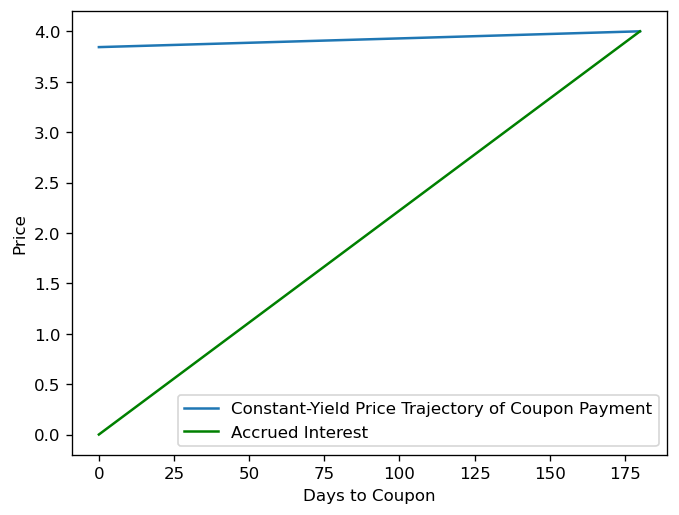

In [11]:
import matplotlib.pyplot as plt

# Present Value of the 1st Coupon Payment - At Issuance 
futurevalue = 4
ytm = 0.08 # semiannual periodicity
ytm_daily = equiv_rate(ytm, from_freq=2, to_freq=360)
n = 180  
pv_0 = pv(ytm_daily/360, n, 0, futurevalue)
print(f'{pv_0 = }')

# Present Value of the 1st Coupon Payment - 89 Days After Issuance
pv_89 = pv(ytm_daily/360, n - 89, 0, futurevalue)
print(f'{pv_89 = }')

n_x = np.linspace(180, 0, num=180)

pv_y = pv(ytm/360, n_x, 0, futurevalue)
accrued_y = n_x/180 * futurevalue

plt.figure(num=0, dpi=120)
plt.plot(180-n_x, pv_y, label='Constant-Yield Price Trajectory of Coupon Payment')
plt.plot(n_x, accrued_y, "g", label="Accrued Interest")
plt.xlabel('Days to Coupon')
plt.ylabel('Price')
plt.legend()

### Treasury Bond Quote Convention

On the Bloomberg Terminal, U.S. Treasury prices are quoted using a specific convention. Here’s a brief overview:
1. **Price Format**: Treasury prices are quoted in terms of full percentage points plus fractions of 1/32 of a point. [For example, a quote might look like 99-032, which means 99 full points plus 3.25/32 of a point](https://www.cmegroup.com/education/courses/introduction-to-treasuries/calculating-us-treasury-pricing.html).
2. **Conversion to Decimal**: To convert this to a decimal, you would calculate it as follows:
    * 99-032 translates to 99 + (3.25/32) = 99.1015625.
3. **Bid and Offer Prices**: The bid and offer prices are often shown in this format. For instance, a bid might be 99-032and an offer 99-03+, where the + represents 1/2 of 1/32.
4. **Futures Prices**: Similar conventions apply to Treasury futures prices. For example, a futures quote of 134-010means 134 full points plus 1/32 of a point, which converts to 134.031251.

A price quoted as 103-00+ on the Bloomberg Terminal can be interpreted as follows:
1. **Full Points**: The 103 represents 103 full percentage points.
2. **Fractions of a Point**: The 00+ indicates fractions of a point. Here, 00 means zero thirty-seconds, and the +represents an additional 1/64 of a point.
So, the + sign means you add 1/64 to the base price. To convert this to a decimal:
* 103-00+ translates to 103 + (0/32) + (1/64).
* This simplifies to 103 + 0 + 0.015625 = 103.015625.
  
Therefore, the price 103-00+ is equivalent to 103.015625 in decimal form.

### Example

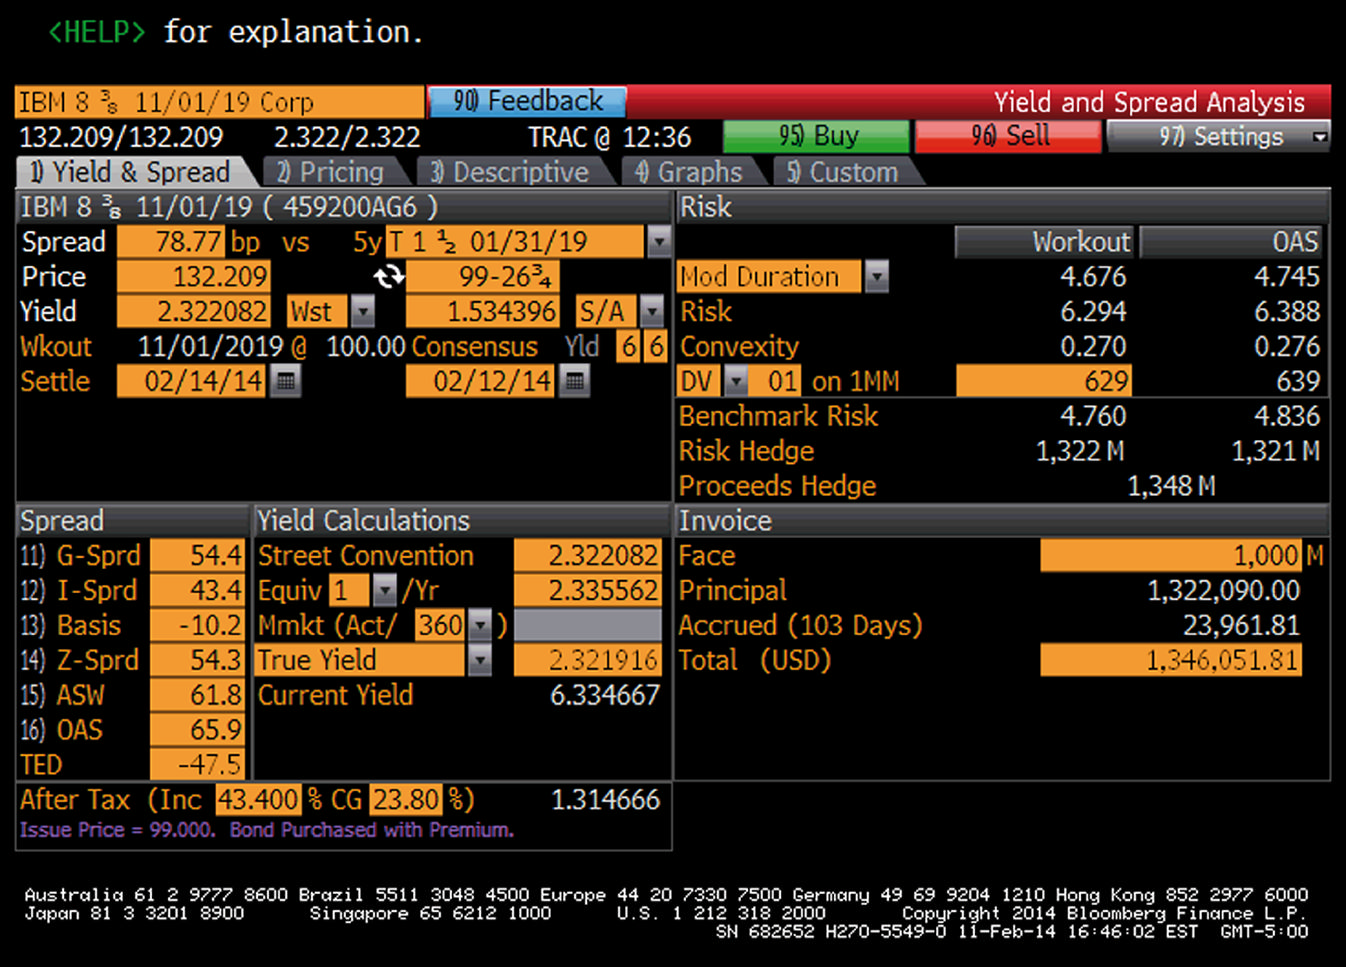

In [12]:
settlement = to_datetime('2014-02-14')
maturity = to_datetime('2019-11-01')
coupon = (8 + (3/8))/100
price = 132.209
face = 100
per = 2
daycount = 'thirty/360'

purchase_amount = 1_000_000 # in face value

# Flat (or clean) price 
flat_price = price * purchase_amount/face
print(f'flat_price = {round(flat_price,2):,}')

# Compute Accrued Interest
coupon_periods = bond_coupon_periods(settle=settlement, mat=maturity, freq=per, daycount=daycount)
accrued_interest = coupon_periods['accrual_fraction'] * coupon/per * purchase_amount
print(f'accrued_interest = {round(accrued_interest,2):,}')

# Compute Full (or Dirty) price
full_price = flat_price + accrued_interest
print(f'full_price = {round(full_price,2):,}')

# Compute Bond Yield - Street convention (on flat price)
street_yield = bond_yield(settle=settlement, cpn = coupon, mat=maturity, price=price, freq = per, redeem=face, daycount=daycount)
print(f'{street_yield = :%}')

# Effective rate
effective_rate = equiv_rate(street_yield, from_freq=2, to_freq=1)
print(f'{effective_rate = :%}')

# Current Yield
current_yield = (coupon*100)/(flat_price/10_000)
print(f'{current_yield = :%}')

# U.S. Government yield
tT_US = bond_coupon_periods(settle=settlement, mat=maturity, freq=per, daycount='actual/actual')['accrual_fraction']
us_yield = gov_equiv_yield(street_yield, coupon_periods['n']/per, pmt=coupon*100, price=full_price/10_000, fv=face, per=per, tT=tT_US)
print(f'{us_yield = :%}')

# Japanese simple yield
N = (maturity-settlement).days/366
simple_yield = ((coupon*100) / price) + ((face - price) / (N*price))
print(f'{simple_yield = :%}')

coupon_periods

flat_price = 1,322,090.0
accrued_interest = 23,961.81
full_price = 1,346,051.81
street_yield = 2.322082%
effective_rate = 2.335562%
current_yield = 6.334667%
us_yield = 2.324031%
simple_yield = 2.060190%


{'n': 12,
 'discounting_fraction': 0.42777777777777776,
 'accrual_fraction': 0.5722222222222222,
 'next_coupon': Timestamp('2014-05-01 00:00:00'),
 'prev_coupon': Timestamp('2013-11-01 00:00:00')}

In [13]:
# Comparable on-the-run Treasury note
settlement_T = to_datetime('2014-02-12')
maturity_T = to_datetime('2019-01-31')
coupon_T = (1 + 1/2)/100
flat_price_T = 99 + (26 + 3/4)/32
face_T = 100
per = 2
daycount_T = 'actual/actual'

yield_T = bond_yield(settle=settlement_T, cpn = coupon_T, mat=maturity_T, price=flat_price_T, freq = per, redeem=face_T, daycount=daycount_T)
print(f'{yield_T = :%}')

# Spread
spread1 = street_yield - yield_T
print(f'{spread1 = :%}')
spread2 = us_yield - yield_T
print(f'{spread2 = :%}')

yield_T = 1.534395%
spread1 = 0.787686%
spread2 = 0.789635%


In [14]:
# True Yield
import pandas as pd
from prettytable import PrettyTable
from importlib import import_module

def coupon_days(start_date, end_date, daycount, freq):
    daycount_dict = {'actual/360': 'actual360', 
                    'actual/365': 'actual365', 
                    'actual/actual': 'actualactual', 
                    'thirty/360': 'thirty360'}    
    name = 'isda_daycounters.'+ daycount_dict[daycount]
    if daycount != 'actual/actual':
        days_in_coupon = import_module(name).year_fraction(start_date, end_date) * freq
        days_in_coupon /= import_module(name).day_count(start_date, end_date)
        days_in_coupon **= -1
    else:
        days_in_coupon = (end_date - start_date).days
    return days_in_coupon

ref_date = maturity
coupon_date = []
dow = []
payment_date = []
discounting_fraction = coupon_periods['discounting_fraction']
discounting_factor = []
cf = []
n = int(per * (maturity - settlement).days / 360)

for i in range(n, -1, -1):
    date = maturity + pd.tseries.offsets.DateOffset(months=-i * 12 /per)
    coupon_date.append(date.date())
    day = date.day_name()
    dow.append(day)
    year_frac = 0
    if day == 'Saturday':
        next_coupon = coupon_date[-1] + pd.tseries.offsets.DateOffset(months=12 /per)
        days_in_coupon = coupon_days(coupon_date[-1], next_coupon, daycount, per)
        year_frac = 2/days_in_coupon
        date += pd.tseries.offsets.DateOffset(day=3)
    elif day == 'Sunday':
        next_coupon = coupon_date[-1] + pd.tseries.offsets.DateOffset(months=12/per)
        days_in_coupon = coupon_days(coupon_date[-1], next_coupon, daycount, per)
        year_frac = 1/days_in_coupon
        date += pd.tseries.offsets.DateOffset(day=2)

    discounting_factor.append(n - i + discounting_fraction + year_frac)        
    
    payment_date.append(date.date())
    
    cf.append(coupon*100/2 if date < maturity else coupon*100/2 + face)

table = PrettyTable()
table.add_column("Coupon Dates", coupon_date)
table.add_column("Weekday", dow)
table.add_column("Payment Date", payment_date)
table.add_column("Discounting Factor", discounting_factor)
table.add_column("Cash Flow", cf)
print(table)

def true_yield(price, cash_flow, discounting_factor, per):
    def present_value(true_yield, cash_flow, discounting_factor, per):
        discount_factors = (1 + true_yield / per) ** (-discounting_factor)
        return np.dot(cash_flow, discount_factors)
    def f(x):
        return present_value(x, cash_flow, discounting_factor, per) - price
    root = newton(f, 0, disp=False)
    return root

result = true_yield(price=full_price/10_000, cash_flow=np.array(cf), discounting_factor=np.array(discounting_factor), per=per)
print(f"Computed IRR (adjusted for periodicity): {result:.6%}")

+--------------+-----------+--------------+---------------------+-----------+
| Coupon Dates |  Weekday  | Payment Date |  Discounting Factor | Cash Flow |
+--------------+-----------+--------------+---------------------+-----------+
|  2014-05-01  |  Thursday |  2014-05-01  | 0.42777777777777776 |   4.1875  |
|  2014-11-01  |  Saturday |  2014-11-03  |  1.4388888888888889 |   4.1875  |
|  2015-05-01  |   Friday  |  2015-05-01  |  2.4277777777777776 |   4.1875  |
|  2015-11-01  |   Sunday  |  2015-11-02  |  3.433333333333333  |   4.1875  |
|  2016-05-01  |   Sunday  |  2016-05-02  |  4.433333333333334  |   4.1875  |
|  2016-11-01  |  Tuesday  |  2016-11-01  |  5.427777777777778  |   4.1875  |
|  2017-05-01  |   Monday  |  2017-05-01  |  6.427777777777778  |   4.1875  |
|  2017-11-01  | Wednesday |  2017-11-01  |  7.427777777777778  |   4.1875  |
|  2018-05-01  |  Tuesday  |  2018-05-01  |  8.427777777777777  |   4.1875  |
|  2018-11-01  |  Thursday |  2018-11-01  |  9.427777777777777  

In [15]:
import math
BASE_TOL = 1e-12

def irr_newton(stream, cf_t, tol=BASE_TOL):
    rate = 0.0
    for steps in range(50):
        r = cf_t
        # Factor exp(m) out of the numerator & denominator for numerical stability
        m = max(-rate * r)
        f = np.exp(-rate * r - m)
        t = np.dot(f, stream)
        if abs(t) < tol * math.exp(-m):
            break
        u = np.dot(f * r, stream)
        # Clip the update to avoid jumping into some numerically unstable place
        rate = rate + np.clip(t / u, -1.0, 1.0)

    return math.exp(rate) - 1

stream = np.insert(np.array(cf), 0, -full_price/10_000, axis=0)
timings = np.insert(np.array(discounting_factor), 0, 0, axis=0)

result = irr_newton(stream=stream, cf_t=timings)
result *= per
print(f"Computed True Yield: {result:.6%}")

Computed True Yield: 2.321916%


In [16]:
import math
import numpy as np

BASE_TOL = 1e-12

def irr_newton(stream, cf_t, per=1, tol=BASE_TOL):
    """
    Compute the IRR using Newton's method with custom cash flow timings and rate periodicity.

    :param stream: array-like, the cash flow amounts.
    :param cf_t: array-like, the custom timings for the cash flows.
    :param per: int, the number of periods per year (default is 1 for annual compounding).
    :param tol: float, the tolerance level for convergence (default: 1e-12).
    :return: the computed internal rate of return (IRR) as an annualized rate.
    """
    rate = 0.0  # Initial guess for the rate (logarithmic scale for numerical stability)
    
    for steps in range(50):  # Limit the number of iterations
        r = np.array(cf_t)

        # Compute the present value of the cash flows using the periodic rate (rate/per)
        m = max(-rate * r / per)  # Numerical stability factor
        f = np.exp(-rate * r / per - m)  # Discounted cash flows
        
        # Calculate the present value of the cash flows
        t = np.dot(f, stream)
        
        # Check for convergence: stop if result is within the tolerance level
        if abs(t) < tol * math.exp(-m):
            break
        
        # Compute the derivative of the present value with respect to rate
        u = np.dot(f * r, stream)
        
        # Update the rate using Newton's method, with clipping for numerical stability
        rate = rate + np.clip(t / u, -1.0, 1.0)
    
    # Convert the logarithmic periodic rate to an annualized rate
    annualized_rate = (math.exp(rate / per) - 1) * per  # Annualized IRR

    return annualized_rate  # Return the annualized rate

# Example usage
stream = np.insert(np.array(cf), 0, -full_price / 10_000, axis=0)  # Insert the initial investment
timings = np.insert(np.array(discounting_factor), 0, 0, axis=0)    # Insert timing for initial investment

# Compute IRR assuming semi-annual compounding (per=2)
result = irr_newton(stream=stream, cf_t=timings, per=2)
print(f"Computed Annualized IRR: {result:.6%}")

Computed Annualized IRR: 2.321916%


### Example 2

In [17]:
# https://quant.stackexchange.com/questions/77684/what-is-the-day-count-basis-of-the-true-yield-reported-by-bloomberg-for-bonds#:~:text=To%20calculate%20the%20true%20yield,%2B3%2B2%2F181.
settlement = to_datetime('2007-08-20')
maturity = to_datetime('2009-02-28')
coupon = 0.0475
full_price = 102.9908288
face = 100
per = 2
daycount = 'actual/actual'

In [18]:
# True Yield
import pandas as pd
from prettytable import PrettyTable
from importlib import import_module

issuance = '2007-02-28'
coupon_date = ['2007-08-31', '2008-02-29', '2008-08-31', '2009-02-28']
payment_date = ['2007-08-31', '2008-02-29', '2008-09-01', '2009-03-02']
discounting_factor = [(to_datetime(coupon_date[0]) - settlement).days / (to_datetime(coupon_date[0]) - to_datetime(issuance)).days]
for i in range(1, len(coupon_date)):
    if coupon_date[i] == payment_date[i]:
        discounting_factor.append(discounting_factor[0] + i)
    else:
        adj = (to_datetime(payment_date[i]) - to_datetime(coupon_date[i])).days / (to_datetime(coupon_date[i]) - to_datetime(coupon_date[i-1])).days
        discounting_factor.append(discounting_factor[0] + i + adj)
cf = [2.375, 2.375, 2.375, 102.375]

table = PrettyTable()
table.add_column("Coupon Dates", coupon_date)
table.add_column("Payment Date", payment_date)
table.add_column("Discounting Factor", discounting_factor)
table.add_column("Cash Flow", cf)
print(table)

def true_yield(price, cash_flow, discounting_factor, per):
    def present_value(true_yield, cash_flow, discounting_factor, per):
        discount_factors = (1 + true_yield / per) ** (-discounting_factor)
        return np.dot(cash_flow, discount_factors)
    def f(x):
        return present_value(x, cash_flow, discounting_factor, per) - price
    root = newton(f, 0, disp=False)
    return root

result = true_yield(price=full_price, cash_flow=np.array(cf), discounting_factor=np.array(discounting_factor), per=per)
print(f"Computed IRR (adjusted for periodicity): {result:.7%}")

+--------------+--------------+----------------------+-----------+
| Coupon Dates | Payment Date |  Discounting Factor  | Cash Flow |
+--------------+--------------+----------------------+-----------+
|  2007-08-31  |  2007-08-31  | 0.059782608695652176 |   2.375   |
|  2008-02-29  |  2008-02-29  |  1.059782608695652   |   2.375   |
|  2008-08-31  |  2008-09-01  |  2.065217391304348   |   2.375   |
|  2009-02-28  |  2009-03-02  |  3.0708323324525586  |  102.375  |
+--------------+--------------+----------------------+-----------+
Computed IRR (adjusted for periodicity): 4.2170846%


### Spread Measure Summary

1) The **G‐Spread** is the street convention yield minus the yield on an interpolated Treasury curve. The idea is to find the point on the government bond yield curve that best matches the maturity of a given bond.
2) **I‐spread** is similar in that it is the bond yield minus the yield on an interpolated interest rate swap curve.
3) The **Basis** relates the bond spread to prices on credit default swaps.
4) The **Z‐spread** is the uniform increment over a benchmark spot (i.e., zero-coupon) curve that obtains the full price of the bond.
5) The **asset swap spread** (ASW) is the difference between the bond’s coupon rate and a corresponding fixed rate on an interest rate swap.
6) The **option‐adjusted spread** (OAS) “corrects” the bond spread for the presence of embedded options.

### Questions

In [19]:
def equivRate(rate, from_freq=1, to_freq=1):
  if from_freq == np.inf:
    return (np.exp(rate / to_freq) - 1) * to_freq
  elif to_freq == np.inf:
    return np.log(1 + rate / from_freq) * from_freq
  else:
    return to_freq * ((1 + rate/from_freq)**(from_freq/to_freq) - 1)

def coupon_bond_ymt(n, pmt, pv, fv=100, cf_freq=1, comp_freq=1, beg=False):
    def f(x):
        return coupon_bond_pv(n=n, pmt=pmt, rate=x, fv=fv, cf_freq=cf_freq, comp_freq=comp_freq, beg=beg) - pv
    root = newton(f, 0)
    return root

def coupon_bond_pv(n, pmt, rate, fv=100, cf_freq=1, comp_freq=1, beg=False):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    old_settings = np.seterr(invalid='ignore')
    pvPMT = np.where(rate == 0, n, np.divide(1 - (1+rate)**-n, rate)) * pmt
    np.seterr(**old_settings)
    pvFV = fv / (1 + rate)**n
    return np.where(beg, (pvPMT + pvFV) * (1 + rate), pvPMT + pvFV)

def coupon_bond_fv(n, pmt, rate, terminal_payment, cf_freq=1, comp_freq=1, beg=False):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    old_settings = np.seterr(invalid='ignore')
    fvPMT = np.where(rate == 0, n, np.divide((1+rate)**n - 1, rate)) * pmt
    np.seterr(**old_settings)        
    return np.where(beg, fvPMT * (1 + rate) + terminal_payment, fvPMT + terminal_payment)

def coupon_bond_pmt(n, rate, pv, fv, cf_freq=1, comp_freq=1):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    pvaf = np.where(rate == 0, n, np.divide(1 - (1+rate)**-n, rate))
    return (pv - (fv/(1+rate)**n)) / pvaf

def zero_bond_ymt(n, pv, fv=100, freq=2):
    if freq == np.inf:
        return np.log(fv/pv) * (1/n)
    return ((fv/pv)**(1/(n*freq)) - 1) * freq

def zero_bond_pv(n, rate, fv=100, freq=2):
    if freq == np.inf:
        return fv / np.exp(rate*n)
    return fv / ((1 + rate/freq)**(n*freq))

def zero_bond_fv(n, rate, pv, freq):
    if freq == np.inf:
        return pv * np.exp(rate*n)    
    return pv * ((1 + rate/freq)**(n*freq))

def irr_newton(cf, cf_t, per=1):
    def price(rate, cf, cf_t, per=1):
        discount_factor = (1 + rate/per)**(-cf_t)
        return np.dot(cf, discount_factor)
    def f(x):
        return price(x, cf, cf_t, per=per)
    return newton(f, 0)

def irr_newton_no_scipy(stream, cf_t, per=1, tol=1e-12):
    rate = 0.0
    for steps in range(50): 
        r = np.array(cf_t)
        m = max(-rate * r / per)  
        f = np.exp(-rate * r / per - m)
        t = np.dot(f, stream)
        if abs(t) < tol * np.exp(-m):
            break
        u = np.dot(f * r, stream)
        rate = rate + np.clip(t / u, -1.0, 1.0)
    annualized_rate = (np.exp(rate / per) - 1) * per 
    return annualized_rate

1.	Market interest rates are observed to be increasing. Which combination of changes in the demand for and supply of money is most likely to explain rising rates?
    1. Decreased demand for money and decreased supply of money.
    2. Decreased demand for money and increased supply of money.
    3. **Increased demand for money and decreased supply of money.**
    4. Increased demand for money and increased supply of money.

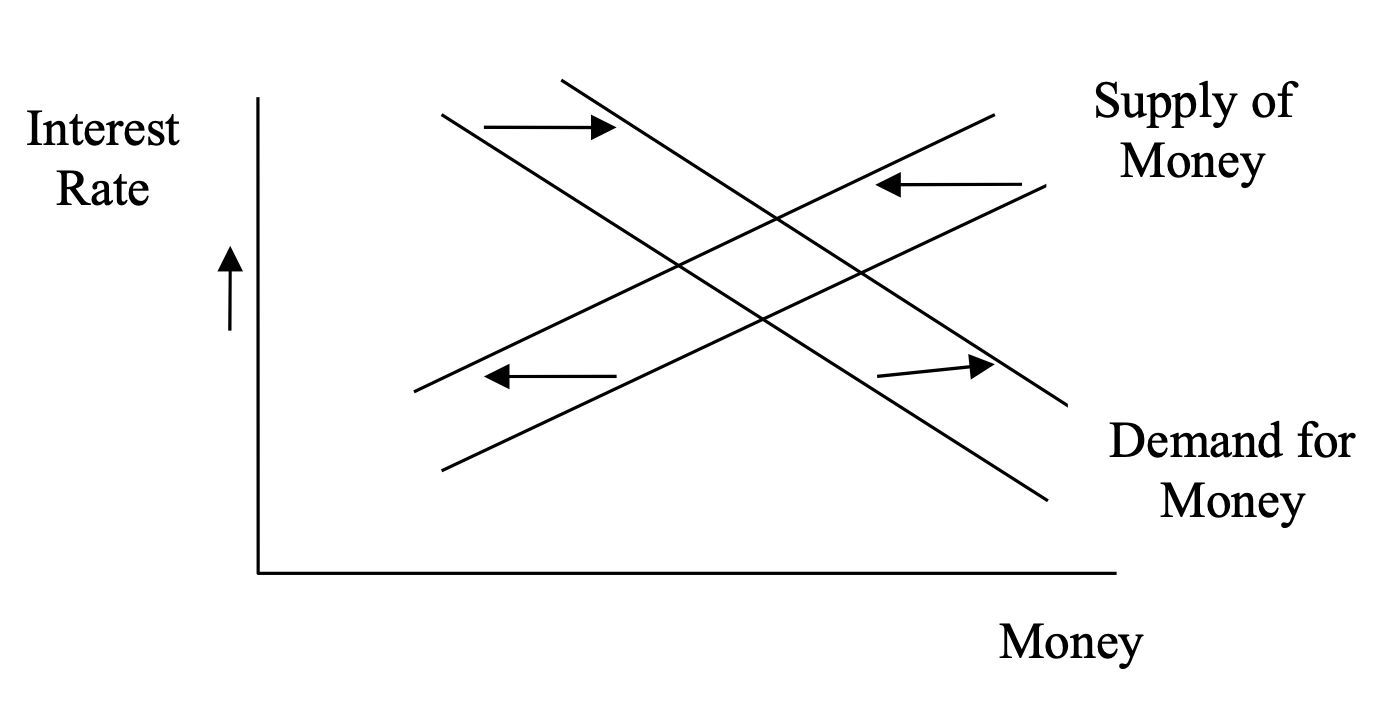

2.	Bond prices are observed to be decreasing. Which combination of changes in the demand for and supply of bonds is most likely to explain falling bond prices?
    1. Decreased demand for bonds and decreased supply of bonds.
    2. Increased demand for bonds and decreased supply of bonds.
    3. **Decreased demand for bonds and increased supply of bonds.**
    4. Increased demand for bonds and increased supply of bonds.

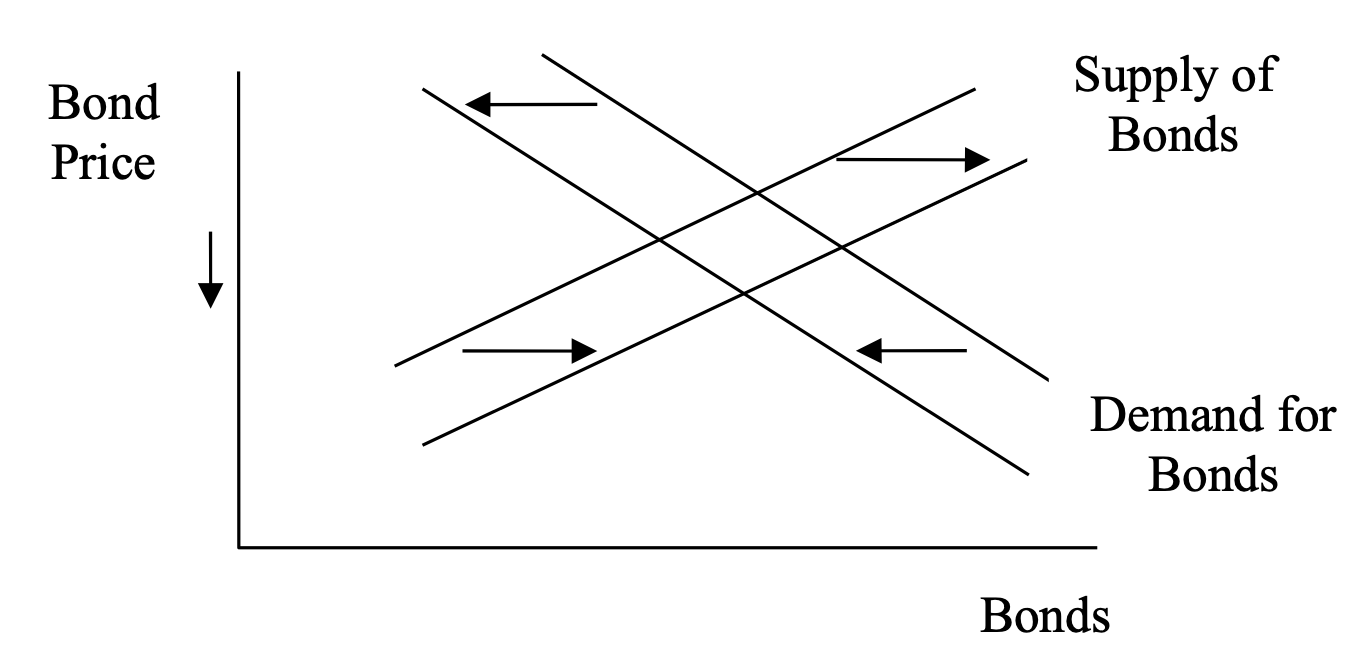

3.	A 5-year, 4% semiannual payment bond is priced at 102 (percent of par value). Its yield to maturity, quoted on a semiannual bond basis having a periodicity of 2, is closest to:

In [20]:
n = 5
coupon = 4
cf_freq = 2
price = 102

rate = coupon_bond_ymt(n*2, coupon/2, price, cf_freq=2, comp_freq=2)
print(f'{rate = :0.3%}')

rate = 3.560%


4.	A 25-year, 6% quarterly coupon payment bond is priced at 108 (percent of par value). Its yield to maturity converted to an annual rate for semiannual compounding is closest to:

In [21]:
n = 25
coupon = 6
cf_freq = 4
price = 108

rate = coupon_bond_ymt(n*cf_freq, coupon/cf_freq, price, cf_freq=cf_freq, comp_freq=2)
print(f'{rate = :0.3%}')

rate = 5.451%


5. A 5-year, 4% semiannual coupon payment corporate bond is priced at 96 (percent of par value). Its yield to maturity converted to an annual rate for monthly compounding is closest to:

In [22]:
n = 5
coupon = 4
cf_freq = 2
price = 96

rate = coupon_bond_ymt(n*cf_freq, coupon/cf_freq, price, cf_freq=cf_freq, comp_freq=2)
print(f'{rate = :0.3%} (s.a.)')

rate = equivRate(rate, 2, 12)
print(f'{rate = :0.3%} (monthly compounding)')

rate = 4.912% (s.a.)
rate = 4.862% (monthly compounding)


6. A 7-year, 4.50% semiannual coupon payment government bond is priced to yield 4.36% (s.a.), indicating a semiannual bond basis. Its price (as a percent of par value) is closest to:

In [23]:
n = 7
coupon = 4.5
ytm = 0.0436
cf_freq = 2
face = 100

price = coupon_bond_pv(n*2, coupon/2, ytm, face, cf_freq=cf_freq, comp_freq=cf_freq)
print(f'{price = :0.4f}')

price = 100.8368


Base your answers to Questions 7 to 9 on these prices for **annual coupon payment** government bonds.

| Maturity | Coupon Rate | Price (% of Par Value) |
| -------- | ----------- | ---------------------- |
| 1 Year   | 0.75%       | 100                    |
| 2 Year   | 1.75%       | 99                     |
| 3 Year   | 4.75%       | 101                    |

In [24]:
maturity = np.arange(3)+1
coupon = np.array([0.0075, 0.0175, 0.0475])
price = np.array([100,99,101])

7. The yield to maturity on the 3-year bond converted to a semiannual bond basis is closest to:

In [25]:
rate = coupon_bond_ymt(3, coupon[2]*100, price[2], 100, cf_freq=1, comp_freq=1)
print(f'{rate = :0.3%} (annual)')

rate = equivRate(rate, 1, 2)
print(f'{rate = :0.3%} (s.a.)')

rate = 4.387% (annual)
rate = 4.340% (s.a.)


8. The yield to maturity on the 2-year bond converted to an annual percentage rate for daily compounding, i.e., a periodicity of 365, is closest to:

In [26]:
rate = coupon_bond_ymt(2, coupon[1]*100, price[1], 100, cf_freq=1, comp_freq=1)
print(f'{rate = :0.3%} (annual)')

rate = equivRate(rate, 1, 365)
print(f'{rate = :0.3%} (daily)')

rate = 2.267% (annual)
rate = 2.242% (daily)


9. An investor buys the 3-year bond at the given price, reinvests the first coupon at 1.25% for one year, and then sells the bond at a price of 99 (percent of par value) immediately after collecting the second coupon payment. The annual rate of return over the 2-year holding period (i.e., the realized 2-year horizon yield) is closest to:

In [27]:
purchase_price = price[2]
selling_price = 99
first_coupon_return = coupon[2]*100*(1 + 0.0125)

cf_year2 = first_coupon_return+(coupon[2]*100)+selling_price

horizon_yield = (cf_year2/purchase_price)**(1/2) - 1
print(f'{horizon_yield = :0.3%}')

horizon_yield = 3.675%


In [28]:
cash_flow = np.array([-purchase_price, 0, cf_year2])

horizon_yield = irr_newton(cash_flow, np.array([0,1,2]), 1)
print(f'{horizon_yield = :0.3%}')

horizon_yield = 3.675%


10. The all-in cost of a 10-year, 5%, semiannual coupon payment bond issued by a corporate borrower at par value and incurring an up-front underwriting commission of 0.80% of par value is closest to:

The initial proceeds of the bond issuance are 99.20 per 100 of par value after subtracting the up-front underwriting commission of 0.80. The all-in cost (note: sometimes **“all-in” refers to the inclusion of costs and sometimes to the inclusion of cash flows on derivatives used to transform the security**) to the corporate borrower is 5.10% per year. This is obtained as an internal rate of return in the same manner as the annualized yield to maturity.

It can be interpreted as an **annual interest rate of 5.00% plus the amortized cost of the underwriting expenses of 0.10%**. Straight-line amortization of those costs would be 0.08% per year (0.80%/10). Including an interest rate into the amortization raises the annual amount by 2 basis points.

In [29]:
n = 10
coupon = 5
cf_freq = 2
face = 100
price = 100
commission = 0.008 * face

# Cost of Borrowing - w/o Fee
ytm = coupon_bond_ymt(n*2, coupon/2, price, face, cf_freq=2, comp_freq=2)
print(f'Cost of Debt (w/o fee) = {ytm:0.2%}')

# Cost of Borrowing - w/ Fee
ytm = coupon_bond_ymt(n*2, coupon/2, (price-commission), face, cf_freq=2, comp_freq=2)
print(f'Cost of Debt (w/ fee) = {ytm:0.2%}')

Cost of Debt (w/o fee) = 5.00%
Cost of Debt (w/ fee) = 5.10%


11. A retail investor is considering two bonds deemed to have the same credit risk and liquidity: Bond (I) a 4%, quarterly payment, 5-year bond priced at 99 (percent of par value); and Bond (II) a 4.25%, annual payment, 5-year bond priced at par value. Which statement best describes the proper advice to the investor?
    1.  Recommend Bond (II) because its coupon rate of 4.25% is greater than 4%, the coupon rate of Bond (I).
    2.  Recommend Bond (II) because its yield to maturity of 4.25% is greater than 4.22%, the yield to maturity of Bond (I).
    3.  Recommend Bond (I) because its price of 99 is less than 100, the price of Bond (II).
    4.  Recommend Bond (I) because its yield to maturity converted to 4.29% on an effective annual rate basis is greater than 4.25%, the yield to maturity on Bond (II).

In [30]:
n = 5 
coupon_1 = 4
price_1 = 99
cf_freq_1 = 4
ytm_1 = coupon_bond_ymt(n*4, coupon_1/4, price_1, 100, cf_freq=cf_freq_1, comp_freq=1)
print(f'{ytm_1 = :0.2%} (annual)')

coupon_2 = 4.25
price_2 = 100
cf_freq_2 = 1
ytm_2 = coupon_bond_ymt(n, coupon_2, price_2, 100, cf_freq=cf_freq_2, comp_freq=1)
print(f'{ytm_2 = :0.2%} (annual)')

ytm_1 = 4.29% (annual)
ytm_2 = 4.25% (annual)


12. The difference between a street convention yield to maturity on a fixed-income bond and the true yield is:
    1. A street convention yield is only an approximation, whereas the true yield is calculated on a computer.
    2. A street convention yield assumes a 360-day year, whereas the true yield assumes a 365-day year.
    3. **A street convention yield assumes that payments are made on scheduled calendar dates neglecting weekends and holidays, whereas the true yield assumes that payments are made on the next business day following a weekend or holiday.**
    4. A street convention yield is the approximation for illiquid bonds that are not actively traded, whereas the true yield is for liquid bonds and is based on actual prices from trades.

13. A 3-year, 5% annual coupon payment corporate bond is priced at 101 (percent of par value) to yield 4.6353%. The risk-free yield curve is flat at 2.75%. Both are effective annual rates having a periodicity of 1. Assume that the recovery rate would be 35% of par value if the corporate bond defaults on a coupon payment date. Using the tabular method, the probability of default for each year is closest to:

In [31]:
# Probability of Default Calculation - Unconditional Probability
from prettytable import PrettyTable

per = 1
n = 3
coupon = 5

# 3-year, 5% annual payment corporate bond
cop_pv = 101
cop_yield = coupon_bond_ymt(n, coupon, cop_pv, 100, cf_freq=per, comp_freq=per)

# equivalent risk-free bond
gov_yield = 0.0275
gov_pv = coupon_bond_pv(n, coupon, gov_yield, 100, cf_freq=per, comp_freq=per)

credit_spread = cop_yield - gov_yield
price_spread = gov_pv - cop_pv

year = np.arange(n) + 1

# Risk-Free Value (value of the corporate bond each year if it were risk free + the coupon received in that period)
riskfree_value = np.vectorize(coupon_bond_pv)(year[::-1], coupon, gov_yield, fv=100, cf_freq=per, comp_freq=per, beg=True)

# Recovery rate of 35% of par value
recovery_rate = 0.35 
recovery = np.full(year.shape, (100 * recovery_rate))

# Default Loss after instantaneous recovery
default_loss = riskfree_value - recovery

# Present value of default loss - risk-free rate is used to discount the losses
pv_default = default_loss * (1 + gov_yield/per)**(-year*per)
Q = price_spread/np.sum(pv_default) # implied default probability
expected_loss = pv_default * Q

print(f'{Q = :.2%}')

# Output Table
table = PrettyTable()
table.add_column("Year", year)
table.add_column("Risk-Free Value", riskfree_value.round(3))
table.add_column("Recovery", recovery)
table.add_column("Default Loss", default_loss.round(3))
table.add_column("PV of Default Loss", pv_default.round(3))
table.add_column("Expected Loss", expected_loss.round(3))
print(table)

approx_implied_default_prob = credit_spread/(1 - recovery_rate)
print(f'{approx_implied_default_prob = :.2%}')

Q = 2.63%
+------+-----------------+----------+--------------+--------------------+---------------+
| Year | Risk-Free Value | Recovery | Default Loss | PV of Default Loss | Expected Loss |
+------+-----------------+----------+--------------+--------------------+---------------+
|  1   |     109.321     |   35.0   |    74.321    |       72.332       |     1.901     |
|  2   |      107.19     |   35.0   |    72.19     |       68.377       |     1.797     |
|  3   |      105.0      |   35.0   |     70.0     |       64.529       |     1.696     |
+------+-----------------+----------+--------------+--------------------+---------------+
approx_implied_default_prob = 2.90%


14. A 6% semiannual coupon payment corporate bond maturing on April 15, 2028, uses the 30/360 day-count method for accrued interest. The coupons are paid on April 15 and October 15 of each year. For settlement on March 5, 2016, the accrued interest as a percentage of par value is closest to:

In [32]:
settlement = to_datetime("2016-03-05")
maturity = to_datetime("2028-04-15")
coupon = 6
daycount = 'thirty/360'
bond_period = bond_coupon_periods(settle=settlement, mat=maturity, freq=2, daycount=daycount)

accrued_interest = bond_period['accrual_fraction'] * coupon/2
print(f'{accrued_interest = :0.4f}')

accrued_interest = 2.3333


15. A 2% semiannual coupon payment Treasury note matures on November 15, 2021. The street convention yield to maturity on the T-note is 2.40% (s.a.) for settlement on October 19, 2014. That settlement date is 157 days into the 184-day coupon period on an actual/actual day-count basis. The flat (or clean) price for the T-note per 100 of par value is closest to:

In [33]:
settlement = to_datetime("2014-10-19")
maturity = to_datetime("2021-11-15")
n = ((2021 - 2014) * 2) + 1
coupon = 2/2
ytm = 0.024
accrual_fraction = 157/184
accrued_interest = accrual_fraction * coupon

bond_price_flat = (coupon_bond_pv(n, coupon, ytm, 100, 2, 2) * ((1 + (ytm/2))**accrual_fraction)) - accrued_interest
print(f'{bond_price_flat = :0.3f}')

bond_price_flat = 97.411


16. A 4.25% semiannual coupon payment corporate bond matures on June 18, 2026. The street convention yield to maturity on the corporate bond is 3.88% (s.a.) for settlement on January 21, 2015. Accrued interest is calculated on a 30/360 day-count basis. The full (or dirty) price for the bond is closest to:

In [34]:
settlement = to_datetime("2015-01-21")
maturity = to_datetime("2026-06-18")
prev_coupon = to_datetime("2014-12-18")
n = ((2026 - 2015) * 2) + 1
coupon = 4.25/2
ytm = 0.0388
accrual_fraction = 33/180

bond_price_full = (coupon_bond_pv(n, coupon, ytm, 100, 2, 2) * ((1 + (ytm/2))**accrual_fraction))
print(f'{bond_price_full = :0.3f}')

bond_price_full = 103.771


17. A 20-year, 4.50% quarterly coupon payment corporate bond is priced at 102.75 (percent of par value). Its yield to maturity converted to a semiannual bond basis having a periodicity of 2 is closest to:

In [35]:
n = 20
coupon = 4.5
cf_freq = 4
price = 102.75
face = 100

ytm = coupon_bond_ymt(n*4, coupon/4, price, face, cf_freq=cf_freq, comp_freq=2)
print(f'{ytm = :0.4%}')

ytm = 4.3175%


18. An investor buys a 4-year, 4.375% annual coupon payment bond at 102 (percent of par value), collects the first coupon and reinvests at 2.25% for the second year, and then reinvests those proceeds along with the receipt of the second coupon at 2.50% for the third year. The investor then sells the bond at a price of 101 (percent of par value) immediately after collecting the third coupon payment. The horizon yield on the bond, i.e., annual holding-period rate of return over the three years, is closest to:

In [36]:
first_coupon = 4.375*(1 + 0.0225)*(1 + 0.025)
second_coupon = 4.375*(1 + 0.025)
third_coupon = 4.375

selling_price = 101
cf = first_coupon + second_coupon + third_coupon + selling_price

purchase_price = 102

hpr = (cf/purchase_price)**(1/3) - 1
print(f'{hpr = : 0.3%}')

hpr =  3.912%


19. A 5-year, 5.75% annual coupon payment high yield corporate bond is priced at 98.50 (percent of par value). The risk-free yield curve for annual coupon payment bonds is flat at 3.25%. Assume that the recovery rate would be 40% of par value if the corporate bond defaults on a coupon payment date. Using the tabular method, the probability of default for each year is closest to

In [37]:
from prettytable import PrettyTable

per = 1
n = 5
coupon = 5.75
cop_pv = 98.5
cop_yield = coupon_bond_ymt(n, coupon, cop_pv, 100, cf_freq=per, comp_freq=per)
gov_yield = 0.0325
gov_pv = coupon_bond_pv(n, coupon, gov_yield, 100, cf_freq=per, comp_freq=per)

recovery_rate = 0.40

credit_spread = cop_yield - gov_yield
price_spread = gov_pv - cop_pv

year = np.arange(n) + 1

riskfree_value = np.vectorize(coupon_bond_pv)(year[::-1], coupon, gov_yield, fv=100, cf_freq=per, comp_freq=per, beg=True)

recovery = np.full(year.shape, (100 * recovery_rate))

default_loss = riskfree_value - recovery

pv_default = default_loss * (1 + gov_yield/per)**(-year*per)
Q = price_spread/np.sum(pv_default) # implied default probability
expected_loss = pv_default * Q

print(f'{Q = :.2%}')

table = PrettyTable()
table.add_column("Year", year)
table.add_column("Risk-Free Value", riskfree_value.round(3))
table.add_column("Recovery", recovery)
table.add_column("Default Loss", default_loss.round(3))
table.add_column("PV of Default Loss", pv_default.round(3))
table.add_column("Expected Loss", expected_loss.round(3))
print(table)

approx_implied_default_prob = credit_spread/(1 - recovery_rate)
print(f'{approx_implied_default_prob = :.2%}')

Q = 4.01%
+------+-----------------+----------+--------------+--------------------+---------------+
| Year | Risk-Free Value | Recovery | Default Loss | PV of Default Loss | Expected Loss |
+------+-----------------+----------+--------------+--------------------+---------------+
|  1   |     114.987     |   40.0   |    74.987    |       72.627       |     2.912     |
|  2   |     112.788     |   40.0   |    72.788    |       68.278       |     2.737     |
|  3   |     110.516     |   40.0   |    70.516    |       64.065       |     2.568     |
|  4   |     108.171     |   40.0   |    68.171    |       59.985       |     2.405     |
|  5   |      105.75     |   40.0   |    65.75     |       56.033       |     2.246     |
+------+-----------------+----------+--------------+--------------------+---------------+
approx_implied_default_prob = 4.76%


20. A 3.50% semiannual coupon payment corporate bond matures on June 27, 2027. The street convention yield to maturity on the bond is 3.23% (s.a.) for settlement on November 7, 2015. Accrued interest is calculated on a 30/360 day-count basis. The flat (or clean) price for the bond is closest to:

In [38]:
settlement = to_datetime('2015-11-07')
maturity = to_datetime('2027-06-27')
prev_coupon = to_datetime('2015-06-27')
coupon = 3.5 / 2
n = (2027 - 2015) * 2 
ytm = 0.0323

accrual_fraction = ((4*30) + 3 + 7)/180
accrued_interest = accrual_fraction * coupon

bond_price_flat = (coupon_bond_pv(n, coupon, ytm, 100, 2, 2) * ((1 + (ytm/2))**accrual_fraction)) - accrued_interest
print(f'{bond_price_flat = :0.3f}')

bond_price_flat = 102.599
